In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

# Trivial Forecasting (rolling mean)

In [4]:
df = pd.DataFrame({'X': np.arange(0,10)})      #generating an input data frame
df['y'] = df.rolling(3).mean()     #  Take the window and write the average as the result

In [5]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [10]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep = ';')
df = df_all[['date', 'Germany']]
df = df.rename(columns = {'date': 'ds',
                         'Germany': 'y'})


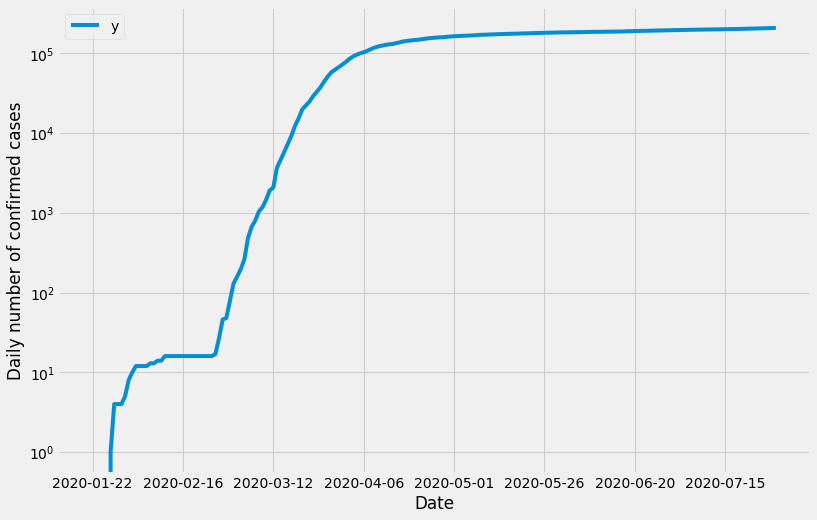

In [11]:
ax = df.set_index('ds').plot(figsize = (12,8),
                            logy = True)
ax.set_ylabel('Daily number of confirmed cases')
ax.set_xlabel('Date')

plt.show()

In [45]:
# Setting the uncertainty interval to 95%
#my_model = Prophet(interval_width = 0.95)
my_model = Prophet(growth = 'logistic')

In [46]:
df['cap'] = 10000000
my_model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future_dates = my_model.make_future_dataframe(periods = 7, freq = 'D')
future_dates['cap'] = 10000000
future_dates.tail()

,ds,cap
192,2020-08-01,10000000
193,2020-08-02,10000000
194,2020-08-03,10000000
195,2020-08-04,10000000
196,2020-08-05,10000000


In [48]:
forecast = my_model.predict(future_dates)

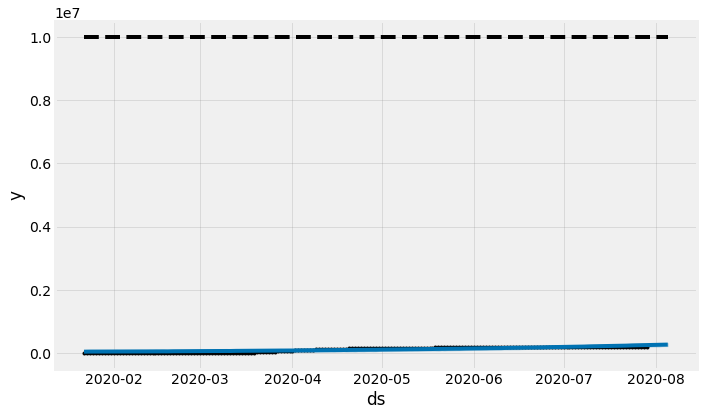

In [49]:
my_model.plot(forecast,
             uncertainty = True);  

In [50]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)

fig.update_layout(
    width = 1024,
    height = 900,
    xaxis_title = "Time",
    yaxis_title = "confirmed infected people",
)
fig.update_yaxes(type = "log", range = [1.1, 5.5])
py.iplot(fig)

In [51]:
forecast.sort_values(by = 'ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,47063.998681,10000000,-11482.477536,97761.621269,47063.998681,47063.998681,-1936.329385,-1936.329385,-1936.329385,-1936.329385,-1936.329385,-1936.329385,0.0,0.0,0.0,45127.669295
1,2020-01-23,47282.686700,10000000,-11037.162746,107684.747097,47282.686700,47282.686700,682.088620,682.088620,682.088620,682.088620,682.088620,682.088620,0.0,0.0,0.0,47964.775320
2,2020-01-24,47502.386027,10000000,-7823.763735,104207.088444,47502.386027,47502.386027,850.464069,850.464069,850.464069,850.464069,850.464069,850.464069,0.0,0.0,0.0,48352.850096
3,2020-01-25,47723.101294,10000000,-4035.257698,107858.365822,47723.101294,47723.101294,629.213532,629.213532,629.213532,629.213532,629.213532,629.213532,0.0,0.0,0.0,48352.314826
4,2020-01-26,47944.837152,10000000,-8566.185433,101131.312911,47944.837152,47944.837152,266.880057,266.880057,266.880057,266.880057,266.880057,266.880057,0.0,0.0,0.0,48211.717209


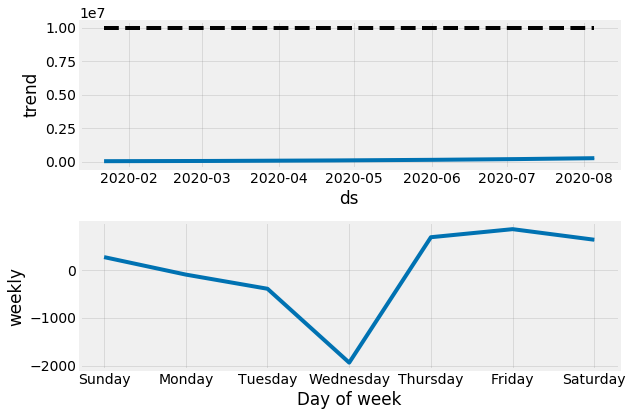

In [52]:
my_model.plot_components(forecast);

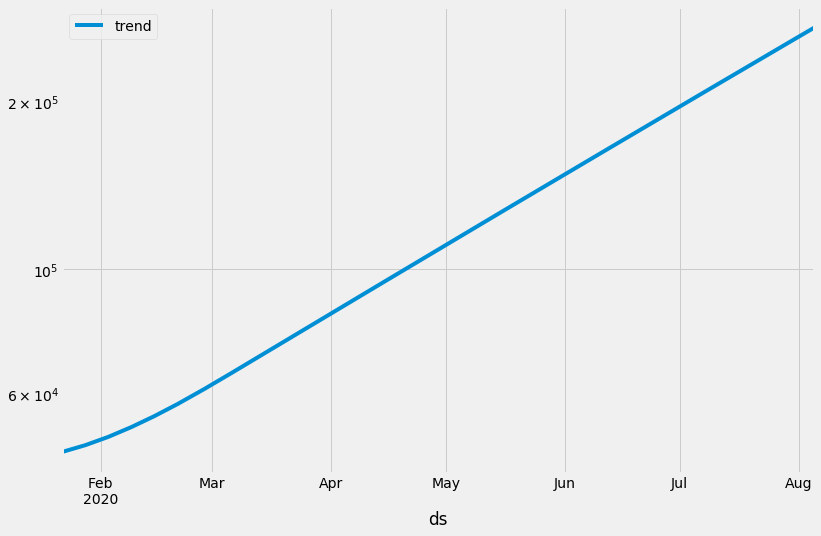

In [53]:
forecast[['ds', 'trend']].set_index('ds').plot(figsize=(12,8), logy = True)

In [54]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model,
                        initial = '30 days',
                        period = '1 days',
                        horizon = '7 days')
df_cv.head()

INFO:fbprophet:Making 153 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-07-22 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
/home/pankaj/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:1256: RuntimeWarning:

overflow encountered in exp

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,23855.396413,23309.803286,24439.414269,16,2020-02-21
1,2020-02-23,8681.358444,8079.031607,9248.865585,16,2020-02-21
2,2020-02-24,8555.352959,7986.319784,9136.372353,16,2020-02-21
3,2020-02-25,8549.670677,7989.534868,9125.620638,17,2020-02-21
4,2020-02-26,-45810.469360,-46425.871993,-45232.691632,27,2020-02-21


In [55]:
df_cv.sort_values(by = ['cutoff','ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,23855.396413,23309.803286,24439.414269,16,2020-02-21
1,2020-02-23,8681.358444,8079.031607,9248.865585,16,2020-02-21
2,2020-02-24,8555.352959,7986.319784,9136.372353,16,2020-02-21
3,2020-02-25,8549.670677,7989.534868,9125.620638,17,2020-02-21
4,2020-02-26,-45810.469360,-46425.871993,-45232.691632,27,2020-02-21
5,2020-02-27,-45804.611521,-46404.620832,-45238.784546,46,2020-02-21
6,2020-02-28,41973.302389,41383.815441,42541.478797,48,2020-02-21
7,2020-02-23,22.527737,18.434745,26.398342,16,2020-02-22
8,2020-02-24,23.922811,19.660576,28.061325,16,2020-02-22
9,2020-02-25,25.851680,22.071051,29.868558,17,2020-02-22


In [56]:
df[['ds','y']][30:]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,17
...,...,...
185,2020-07-25,206278
186,2020-07-26,206667
187,2020-07-27,207112
188,2020-07-28,207707


In [57]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [58]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.524175e+09,39040.687384,33641.861851,10.073915,0.253662,0.196078
1,2 days,2.149832e+09,46366.283504,38967.172949,5.917315,0.276403,0.098039
2,3 days,1.087019e+11,329699.781018,68404.724468,36.828867,0.303291,0.065359
3,4 days,5.978182e+11,773187.038269,109316.432676,63.616671,0.327434,0.026144
4,5 days,6.548453e+11,809225.125205,117921.113617,67.003930,0.354614,0.019608
5,6 days,6.575970e+11,810923.544466,124118.000399,51.838676,0.384238,0.000000
6,7 days,6.586551e+11,811575.673527,130903.231862,40.486421,0.415377,0.000000


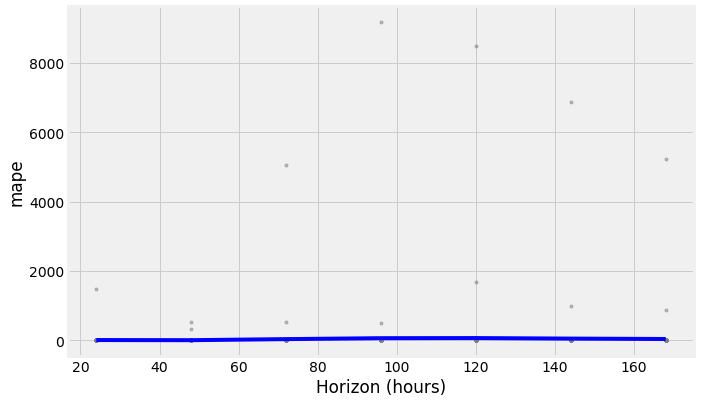

In [59]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = 'mape',)

# Diagonal plot

In [60]:
horizon = '7 days'
df_cv['horizon'] = df_cv.ds-df_cv.cutoff

date_vec = df_cv[df_cv['horizon'] == horizon]['ds']
y_hat = df_cv[df_cv['horizon'] == horizon]['yhat']
y = df_cv[df_cv['horizon'] == horizon]['y']

In [61]:
df_cv_7 = df_cv[df_cv['horizon'] == horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1042,2020-07-25,268075.046546,210599.349534,319912.304557,206278,2020-07-18,7 days
1049,2020-07-26,268567.695194,214850.320360,322176.124655,206667,2020-07-19,7 days
1056,2020-07-27,269428.257574,212853.682989,320207.803371,207112,2020-07-20,7 days
1063,2020-07-28,268532.663127,217080.434706,319149.085203,207707,2020-07-21,7 days
1070,2020-07-29,267040.886197,213887.822412,322703.453918,208546,2020-07-22,7 days


In [62]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

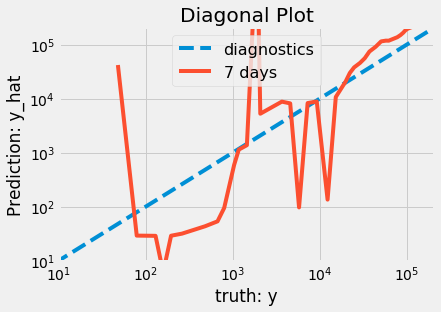

In [63]:
fig, ax = plt.subplots(1,1)

ax.plot(np.arange(max(y)), np.arange(max(y)), '--', label = 'diagnostics')
ax.plot(y,y_hat, '-', label = horizon)

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('Prediction: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc = 'best',
         prop = {'size': 16})

# Trivial forecast

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
parse_dates = ['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep = ';', parse_dates = parse_dates)
df_trivial = df_all[['date', 'Germany']]
df_trivial = df_trivial.rename(columns = {'date': 'ds',
                                         'Germany': 'y'})

In [68]:
df_trivial['y_mean_r3'] = df_trivial.y.rolling(3).mean()

In [70]:
df_trivial['cutoff'] = df_trivial['ds'].shift(7)
df_trivial['y_hat'] = df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon'] = df_trivial['ds']-df_trivial['cutoff']
print('MAPE:   '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE:   159.6693746394989


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
...,...,...,...,...,...,...
185,2020-07-25,206278,205594.000000,2020-07-18,201973.666667,7 days
186,2020-07-26,206667,206189.333333,2020-07-19,202402.000000,7 days
187,2020-07-27,207112,206685.666667,2020-07-20,202828.666667,7 days
188,2020-07-28,207707,207162.000000,2020-07-21,203259.000000,7 days
